In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Загрузка датасета из CSV файла
dataset = pd.read_csv('CardioGoodFitness.csv')

# с ограничением в 25 строк
# male_dataset = dataset[dataset['Gender'] == 'Male'].head(25)
# female_dataset = dataset[dataset['Gender'] == 'Female'].head(25)

m_dataset = dataset[dataset['Gender'] == 'Male']
f_dataset = dataset[dataset['Gender'] == 'Female']

print("Количество записей в выборках: ", len(m_dataset), len(f_dataset))

# Вывод выборок
print("\nВыборка со значением Male в колонке Gender:")
print(m_dataset)

print("\nВыборка со значением Female в колонке Gender:")
print(f_dataset)

Количество записей в выборках:  104 76

Выборка со значением Male в колонке Gender:
    Product  Age Gender  Education MaritalStatus  Usage  Fitness  Income  \
0     TM195   18   Male         14        Single      3        4   29562   
1     TM195   19   Male         15        Single      2        3   31836   
3     TM195   19   Male         12        Single      3        3   32973   
4     TM195   20   Male         13     Partnered      4        2   35247   
7     TM195   21   Male         13        Single      3        3   32973   
..      ...  ...    ...        ...           ...    ...      ...     ...   
175   TM798   40   Male         21        Single      6        5   83416   
176   TM798   42   Male         18        Single      5        4   89641   
177   TM798   45   Male         16        Single      5        5   90886   
178   TM798   47   Male         18     Partnered      4        5  104581   
179   TM798   48   Male         18     Partnered      4        5   95508   

   

 Рассмотрим доход (Income) для двух выборок: мужчины и женщины


Выборочное среднее выборки 1: 56562.75961538462
Выборочное среднее выборки 2: 49828.90789473684
Выборочная дисперсия выборки 1: 339358580.63097453
Выборочная дисперсия выборки 2: 157695588.88473684


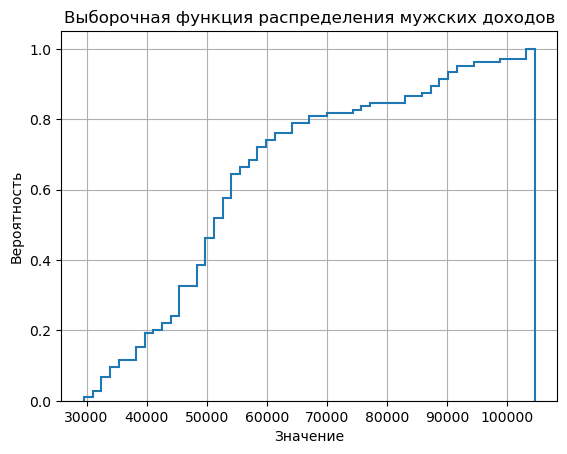

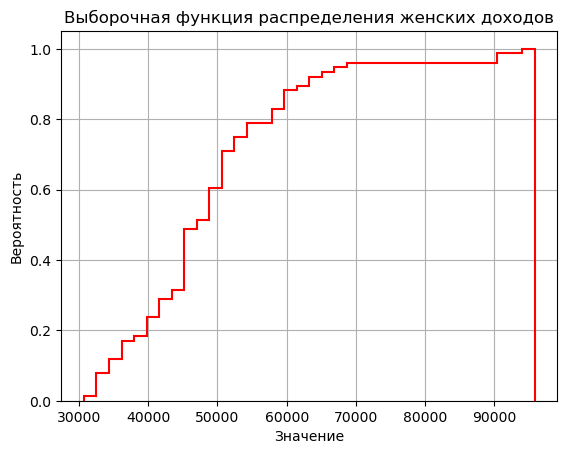

In [3]:
# Извлечение необходимого столбца
sample1 = m_dataset['Income']
sample2 = f_dataset['Income']

# Вычисление выборочного среднего
mean1 = sample1.mean()
mean2 = sample2.mean()

# Вычисление выборочной дисперсии
variance1 = sample1.var(ddof=1)
variance2 = sample2.var(ddof=1)

# Вычисление выборочной функции распределения
cdf1 = np.cumsum(sample1) / sample1.sum()
cdf2 = np.cumsum(sample2) / sample2.sum()

# Вывод результатов
print("\nВыборочное среднее выборки 1:", mean1)
print("Выборочное среднее выборки 2:", mean2)
print("Выборочная дисперсия выборки 1:", variance1)
print("Выборочная дисперсия выборки 2:", variance2)


# plt.plot(np.sort(sample1), cdf1, marker='.', linestyle='none')
# Построение выборочной функции распределения выборки 1
plt.hist(sample1, bins=len(sorted(set(sample1))), density=True, cumulative=True, histtype='step', linewidth=1.5)
plt.xlabel('Значение')
plt.ylabel('Вероятность')
plt.title('Выборочная функция распределения мужских доходов')
plt.grid(True)
plt.show()


# plt.plot(np.sort(sample2), cdf2, marker='.', linestyle='none')
# Построение выборочной функции распределения выборки 2
plt.hist(sample2, bins=len(sorted(set(sample2))), density=True, cumulative=True, histtype='step', linewidth=1.5, color='red')
plt.xlabel('Значение')
plt.ylabel('Вероятность')
plt.title('Выборочная функция распределения женских доходов')
plt.grid(True)
plt.show()

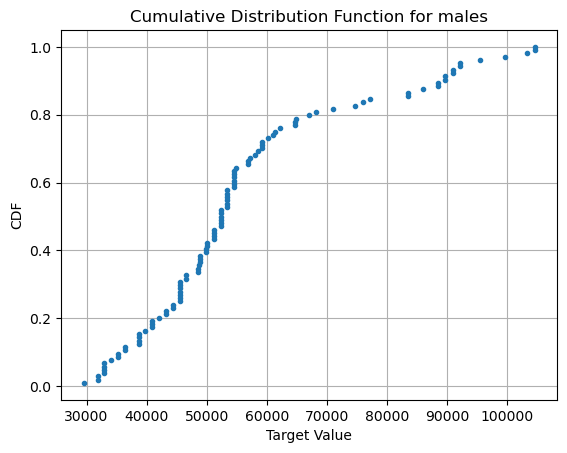

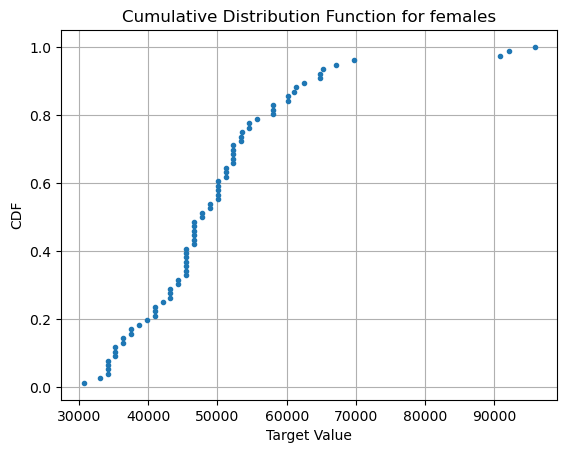

In [5]:
# второй способ построения выборочной функции распределения
# построение выборочной функции распределения с помощью точечного графика
def plot_cdf(targets, name, same_plot=True):
    targets_sorted = np.sort(targets)
    cdf = np.arange(1, len(targets) + 1) / len(targets)
    
    plt.plot(targets_sorted, cdf, marker='.', linestyle='none')
    if not same_plot:
        plt.title(f"Cumulative Distribution Function for {name}")
    plt.xlabel('Target Value')
    plt.ylabel('CDF')
    plt.grid(True)
    if not same_plot:
        plt.show()

plot_cdf(sample1, 'males', same_plot=False) 
plot_cdf(sample2, 'females', same_plot=False) 

Разделяем на обучающие и валидационные выборки

In [5]:
# Размеры массивов для обучения и валидации
n1 = len(sample1)
n2 = len(sample2)

print("Количество записей в выборках: ", n1, n2)
train_size1 = int(n1 * 0.75)  # 75% для обучения
val_size1 = n1 - train_size1  # 25% для валидации
train_size2 = int(n2 * 0.75)  # 75% для обучения
val_size2 = n1 - train_size2  # 25% для валидации

# Разделение на обучающую и валидационную выборки 
train_sample1 = sample1[:train_size1]
valid_sample1 = sample1[train_size1:]
train_sample2 = sample2[:train_size2]
valid_sample2 = sample2[train_size2:]

print("train1:", len(train_sample1), " valid1:", len(valid_sample1))
print("train2:",len(train_sample2), " valid2:", len(valid_sample2))

Количество записей в выборках:  104 76
train1: 78  valid1: 26
train2: 57  valid2: 19


 Находим $\hat{\alpha_1}$ $\hat{\beta_1}$ $\hat{\alpha_2}$ $\hat{\beta_2}$ на обучающих выборках

In [6]:
def distr_func(samples, x):
    return np.sum(samples <= x) / len(samples)

def distr(alpha, beta, x):
    return 1 - np.exp(-alpha * x ** beta)

# Метод наименьших квадратов 
# использование минимизации суммы квадратов разностей между подсчитанными и наблюдаемыми значениями.
def squared_sum(params, samples):
    alpha, beta = params
    # гипотетическое значение     
    hyp_values = list(map(lambda x: distr(alpha, beta, x), xs))
    # целевое значение     
    target_values = list(map(lambda x: distr_func(samples, x), xs))
    return np.sum((np.array(hyp_values) - np.array(target_values))**2)

scale = 100000.0
lst1 = [x/scale for x in train_sample1]
lst2 = [x/scale for x in train_sample2]

samples = lst1
xs = np.arange(min(samples), max(samples), (max(samples) - min(samples)) / 100)
values = list(map(lambda x: distr_func(samples, x), xs))

initial_guess = [0, 0]
result = minimize(squared_sum, initial_guess, args=(samples,))
alpha1, beta1 = result.x
print("Оценка alpha1:", alpha1)
print("Оценка beta1:", beta1)

samples = lst2
xs = np.arange(min(samples), max(samples), (max(samples) - min(samples)) / 100)
values = list(map(lambda x: distr_func(samples, x), xs))

initial_guess = [0, 0]
result = minimize(squared_sum, initial_guess, args=(samples,))
alpha2, beta2 = result.x
print("Оценка alpha2:", alpha2)
print("Оценка beta2:", beta2)

Оценка alpha1: 52.04349914577807
Оценка beta1: 6.010937383103263
Оценка alpha2: 84.39680155711912
Оценка beta2: 6.140062132498764


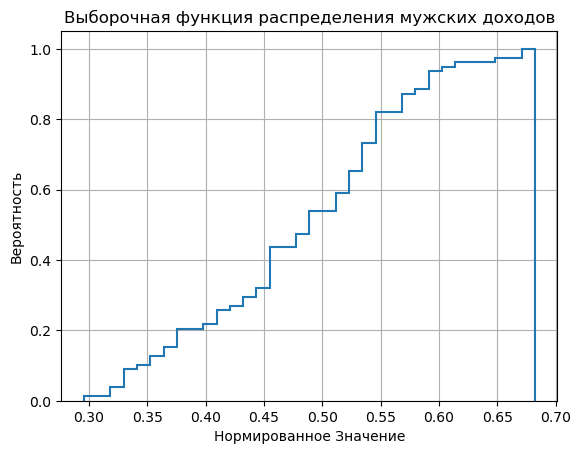

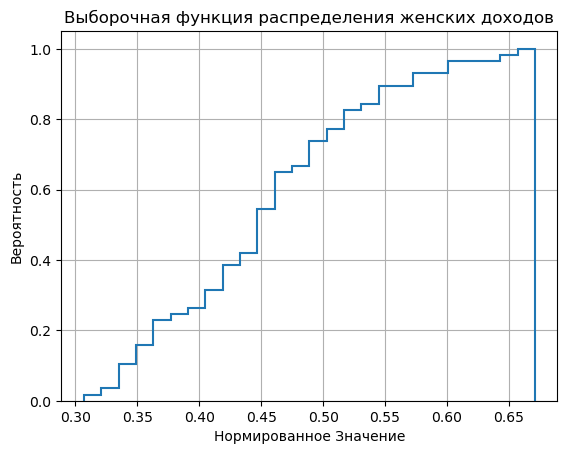

In [19]:
# распределение Вейбулла
def F(x, a, b):
    return 1- np.exp(-a * x**b)

unique_values1 = sorted(set(lst1))
unique_values2 = sorted(set(lst2))

plt.hist(lst1, bins=len(unique_values1), density=True, cumulative=True, histtype='step', linewidth=1.5)
plt.xlabel('Нормированное Значение')
plt.ylabel('Вероятность')
plt.title('Выборочная функция распределения мужских доходов')
plt.grid(True)
plt.show()

# unique_values2 = sorted(set(lst2))
plt.hist(lst2, bins=len(unique_values2), density=True, cumulative=True, histtype='step', linewidth=1.5)
plt.xlabel('Нормированное Значение')
plt.ylabel('Вероятность')
plt.title('Выборочная функция распределения женских доходов')
plt.grid(True)
plt.show()


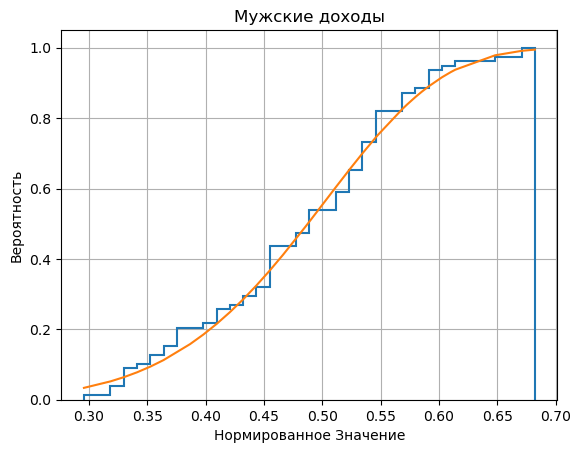

In [17]:
res1 = [F(x, alpha1, beta1) for x in unique_values1]
plt.hist(lst1, bins=len(unique_values1), density=True, cumulative=True, histtype='step', linewidth=1.5)
plt.plot(unique_values1, res1)
plt.xlabel('Нормированное Значение')
plt.ylabel('Вероятность')
plt.title('Мужские доходы')
plt.grid(True)
plt.show()

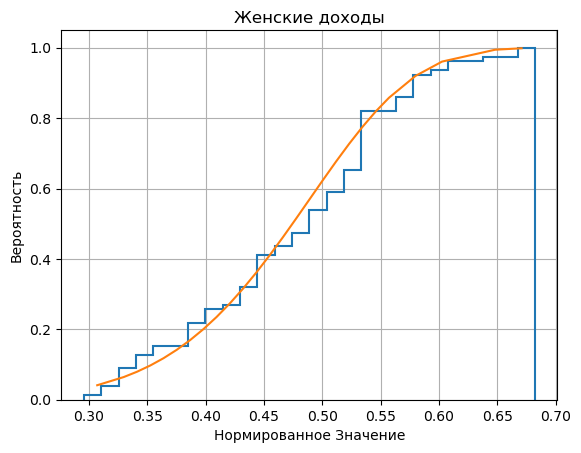

In [18]:
alpha2 = 84.39680155711912
beta2 = 6.440062132498764
res2 = [F(x, alpha2, beta2) for x in unique_values2]
plt.hist(lst1, bins=len(unique_values2), density=True, cumulative=True, histtype='step', linewidth=1.5)
plt.plot(unique_values2, res2)
plt.xlabel('Нормированное Значение')
plt.ylabel('Вероятность')
plt.title('Женские доходы')
plt.grid(True)
plt.show()

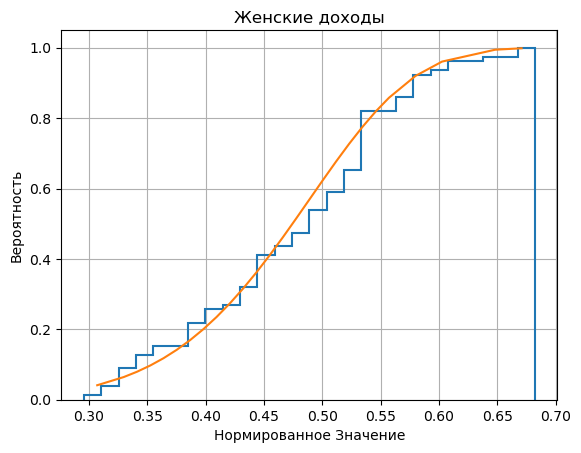

In [15]:
# распределение Вейбулла
def F(x, a, b):
    return 1- np.exp(-a * x**b)

unique_values2 = sorted(set(lst2))

aaa2 = 84.39680155711912
bbb2 = 6.440062132498764
res2 = [F(x, aaa2, bbb2) for x in unique_values2]
plt.hist(lst1, bins=len(unique_values2), density=True, cumulative=True, histtype='step', linewidth=1.5)
plt.plot(unique_values2, res2)
plt.xlabel('Нормированное Значение')
plt.ylabel('Вероятность')
plt.title('Женские доходы')
plt.grid(True)
plt.show()

Оценка alpha1: 1.5055225198746455e-07
Оценка beta1: 1.4356096044273463
Оценка alpha2: 1.5055225198746455e-07
Оценка beta2: 1.4356096044273463


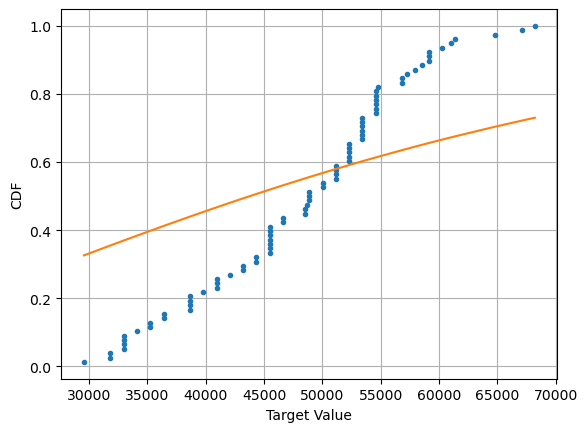

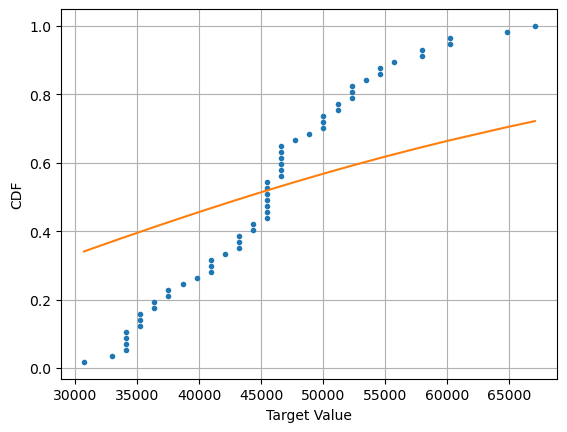

In [10]:
# или 
samples = train_sample1
samples = train_sample2

xs = np.arange(min(samples), max(samples), (max(samples) - min(samples)) / 100)
values = list(map(lambda x: distr_func(samples, x), xs))

initial_guess = [0, 0]
result = minimize(squared_sum, initial_guess, args=(samples,))
alpha11, beta11 = result.x
print("Оценка alpha1:", alpha11)
print("Оценка beta1:", beta11)

xs = np.arange(min(samples), max(samples), (max(samples) - min(samples)) / 100)
values = list(map(lambda x: distr_func(samples, x), xs))

initial_guess = [0, 0]
result = minimize(squared_sum, initial_guess, args=(samples,))
alpha22, beta22 = result.x
print("Оценка alpha2:", alpha22)
print("Оценка beta2:", beta22)


x = np.sort(train_sample1)
def F1(x):
    return 1 - np.exp(-alpha11*(x**beta11))

plot_cdf(train_sample1, 'Male')
plt.plot(x, F1(x))
plt.show()

x = np.sort(train_sample2)

def F2(x):
    return 1 - np.exp(-alpha22*(x**beta22))

plot_cdf(train_sample2, 'Female')
plt.plot(x, F2(x))
plt.show()

Критерий согласия Колмогорова-Смирнова

In [20]:
from scipy.stats import kstest

def kolmogorov_smirnov_test(data, cdf):
    # Выполняем тест Колмогорова-Смирнова
    ks_statistic, p_value = kstest(data, cdf)
    if p_value < 0.05:
        print("Не подходит")
    else:
        print("Подходит")
    return ks_statistic, p_value

In [21]:
kolmogorov_smirnov_test(lst1, res1)

Не подходит


(0.4155354449472097, 0.0003294845125134829)

In [22]:
kolmogorov_smirnov_test(lst2, res2)

Не подходит


(0.40553306342780027, 0.0035175570556935853)

In [23]:
lst1_valid = [x/scale for x in valid_sample1]
resF1 = [F(x, alpha1, beta1) for x in sorted(set(lst1_valid))]
kolmogorov_smirnov_test(lst1_valid, resF1)

Не подходит


(0.6965811965811965, 1.916098865062767e-05)

In [24]:
lst2_valid = [x/scale for x in valid_sample2]
resF2 = [F(x, alpha2, beta2) for x in sorted(set(lst2_valid))]
kolmogorov_smirnov_test(lst2_valid, resF2)

Не подходит


(0.6228070175438597, 0.0007141129895881553)

In [18]:
# проверяем другой вариант
x = np.sort(train_sample1)
kolmogorov_smirnov_test(train_sample1, F1(x))

Не подходит


(1.0, 3.4329611587646166e-46)

In [19]:
x = np.sort(train_sample2)
kolmogorov_smirnov_test(train_sample2, F2(x))

Не подходит


(1.0, 1.2914429985198208e-33)

In [20]:
x = np.sort(valid_sample1)
kolmogorov_smirnov_test(valid_sample1, F1(x))

Не подходит


(1.0, 4.03292046399341e-15)

In [21]:
x = np.sort(valid_sample2)
kolmogorov_smirnov_test(valid_sample2, F2(x))

Не подходит


(1.0, 5.6584667505013764e-11)

In [42]:
def kolmogorov(y1, y2, sample_len=10//4*3):
    eps = 0.01
    Dn = max(abs(y1[i] - y2[i]) for i in range(len(y1)))
    betta = 0.01
    Db = 1 / np.sqrt(sample_len) * np.sqrt(-0.5*np.log(betta))
#     print(Dn, Db)
    return (Dn - Db) <= eps


print("Критерий Колмогорова для выборки 1:", kolmogorov(list(set(lst1)), res1))
print("Критерий Колмогорова для выборки 2:", kolmogorov(list(set(lst2)), res2))

Критерий Колмогорова для выборки 1: True
Критерий Колмогорова для выборки 2: True


In [43]:
def kolmogorov(y1, y2, sample_len):
    eps = 0.01
    Dn = max(abs(y1[i] - y2[i]) for i in range(len(y1)))
    betta = 0.01
    Db = 1 / np.sqrt(sample_len) * np.sqrt(-0.5*np.log(betta))
    print(Dn, Db)
    return (Dn - Db) <= eps


print("Критерий Колмогорова для выборки 1:", kolmogorov(list(set(lst1)), res1, len(res1)))
print("Критерий Колмогорова для выборки 2:", kolmogorov(list(set(lst2)), res2, len(res2)))

0.5080353607846471 0.2602366057464112
Критерий Колмогорова для выборки 1: False
0.49814275766273997 0.29759194396884403
Критерий Колмогорова для выборки 2: False


Находим $\hat{\alpha}$ $\hat{\beta}$

Подтвердить гипотезу о функции связи $\xi_1=\varphi(\xi_2)$ ,
$\xi_1=\alpha\xi_2^\beta$

1.0870559093718484
alpha^:  0.3742655836811461  beta^: 1.0870559093718484


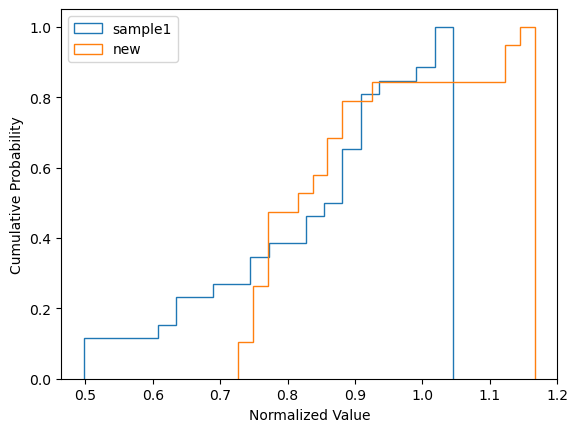

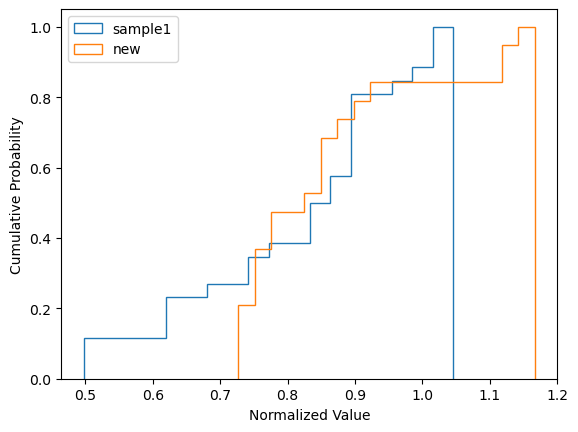

In [27]:
s1 = valid_sample1.var(ddof=1)
s2 = valid_sample2.var(ddof=1)

betta = (s1/s2)**(1/2)
print(betta)

# betta = (s1**2/s2**2)**(1/2)
# print(betta)

L1 = np.mean(np.log(valid_sample1))
L2 = np.mean(np.log(valid_sample1))
alphaa = np.exp(L1 - betta*L2)

print("alpha^: ", alphaa, " beta^:", betta)

sample2_new = [alphaa*i**betta for i in valid_sample2]


scale = 100000.0
smpl1 = [x/scale for x in valid_sample1]
smpl2 = [x/scale for x in valid_sample2]

samples = smpl1
xs = np.arange(min(samples), max(samples), (max(samples) - min(samples)) / 100)
values = list(map(lambda x: distr_func(samples, x), xs))
result1 = minimize(squared_sum, [0, 0], args=(samples,))

samples = smpl2
xs = np.arange(min(samples), max(samples), (max(samples) - min(samples)) / 100)
values = list(map(lambda x: distr_func(samples, x), xs))
result2 = minimize(squared_sum, [0, 0], args=(samples,))

betta = result2.x[1] / result1.x[1]
alphaa = (result2.x[0] / result1.x[0]) ** (1 / result1.x[1])
# print("alpha^: ", alphaa, " beta^:", betta)

new_s2 = [alphaa*i**betta for i in smpl2]
plt.figure()
plt.hist(smpl1, bins=20, density=True, histtype='step', cumulative=True)
plt.hist(new_s2, bins=20, density=True, histtype='step', cumulative=True)
plt.legend(['sample1', 'new'])
plt.xlabel('Normalized Value')
plt.ylabel('Cumulative Probability')
plt.show()


plt.figure()
plt.hist(smpl1, bins=len(sorted(set(smpl1))), density=True, histtype='step', cumulative=True)
plt.hist(new_s2, bins=len(sorted(set(new_s2))), density=True, histtype='step', cumulative=True)
plt.legend(['sample1', 'new'])
plt.xlabel('Normalized Value')
plt.ylabel('Cumulative Probability')
plt.show()

In [45]:
print(alpha1/alpha2)

0.6166525056113107


In [26]:
print(beta1/beta2)

0.9333663650184382


In [48]:
s1 = valid_sample1.var(ddof=1)
s2 = valid_sample2.var(ddof=1)

betta = (s1/s2)**(1/2)
# print(betta)

# betta = (s1**2/s2**2)**(1/2)
# print(betta)

L1 = np.mean(np.log(valid_sample1))
L2 = np.mean(np.log(valid_sample1))
alphaa = np.exp(L1 - betta*L2)

print("alpha^: ", alphaa, " beta^:", betta)

alpha^:  0.3742655836811461  beta^: 1.0870559093718484
